In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

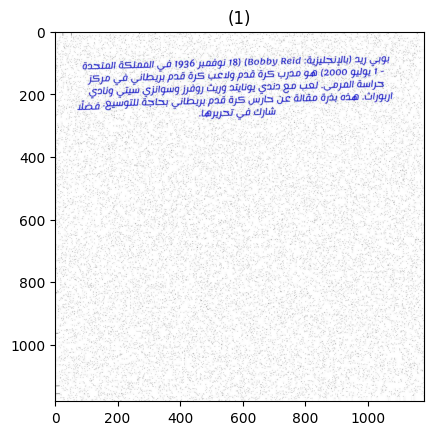

In [4]:
# 1) Text Alignment
import cv2
image = cv2.imread("D:\Third_Year\\Neural\data_set\\fonts-dataset\Lemonada\\482.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
otsu_thresh, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
kernel_size = 4
ksize=(kernel_size, kernel_size)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize)
thresh_filtered = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
nonZeroCoordinates = cv2.findNonZero(thresh_filtered)
imageCopy = image.copy()
for pt in nonZeroCoordinates:
    imageCopy = cv2.circle(imageCopy, (pt[0][0], pt[0][1]), 1, (255, 0, 0))
box = cv2.minAreaRect(nonZeroCoordinates)
boxPts = cv2.boxPoints(box)
for i in range(4):
    pt1 = (int(boxPts[i][0]), int(boxPts[i][1]))
    pt2 = (int(boxPts[(i+1)%4][0]), int(boxPts[(i+1)%4][1]))
    cv2.line(imageCopy, pt1, pt2, (0,255,0), 2, cv2.LINE_AA)
angle = box[2]
if(angle < -45):
    angle = 90 + angle
h, w, c = image.shape
scale = 1.
center = (w/2., h/2.)
M = cv2.getRotationMatrix2D(center, angle, scale)
rotated = image.copy()
cv2.warpAffine(image, M, (w, h), rotated, cv2.INTER_CUBIC, cv2.BORDER_REPLICATE )
show_images([rotated])

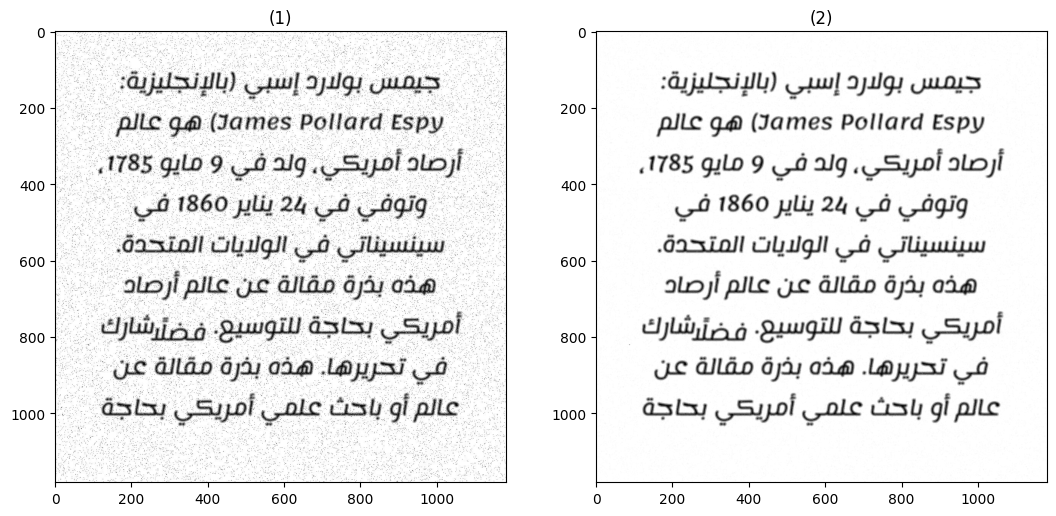

In [5]:
# 2) Salt and pepper noise using median filter
import cv2
import numpy as np

image = cv2.imread("D:\Third_Year\\Neural\data_set\\fonts-dataset\Lemonada\\508.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
median = cv2.medianBlur(gray, 3)
show_images([gray, median])

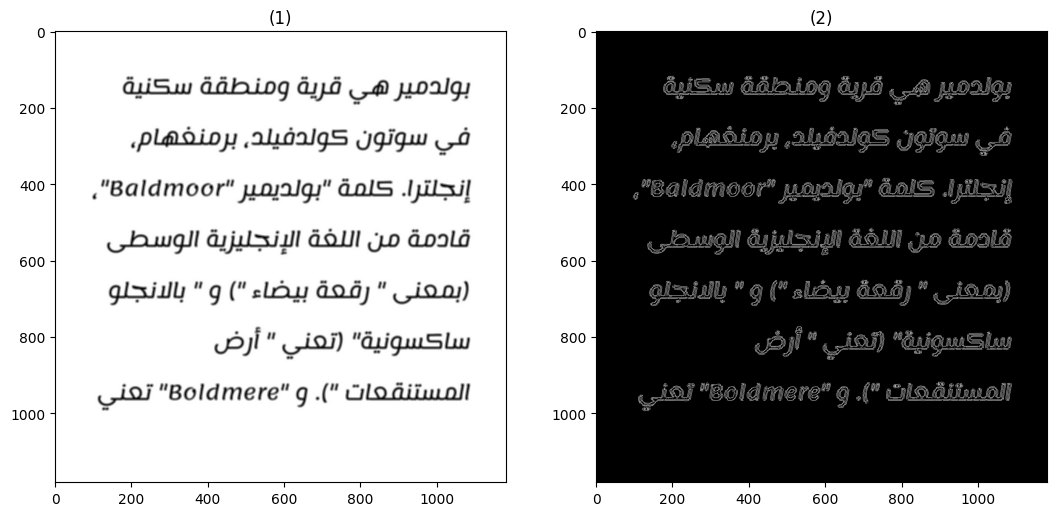

In [6]:
# 3) Image blur
image = cv2.imread("D:\Third_Year\\Neural\data_set\\fonts-dataset\Lemonada\\35.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
median = cv2.medianBlur(gray, 3)
sharpen = cv2.Canny(median, 100,200)
show_images([image, sharpen])

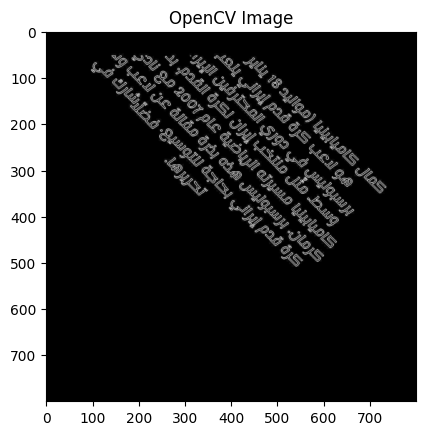

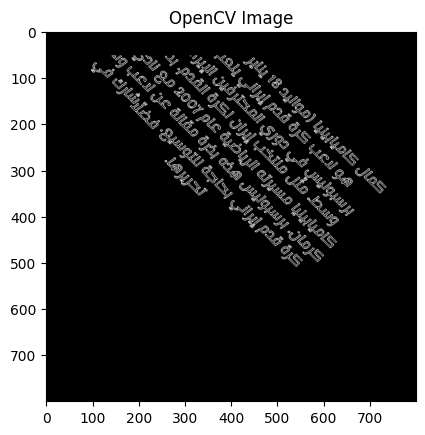

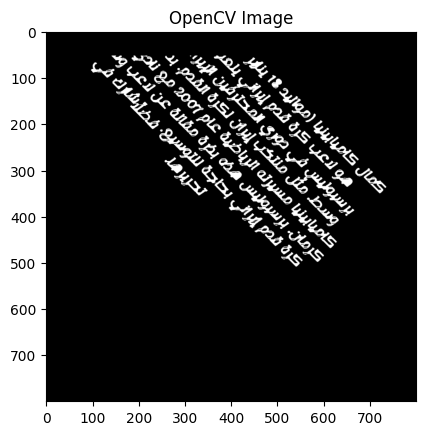

C:\Users\DELL\AppData\Local\Temp\ipykernel_404\1793682143.py:99: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Image orientation in degress:  -40.955072928273125


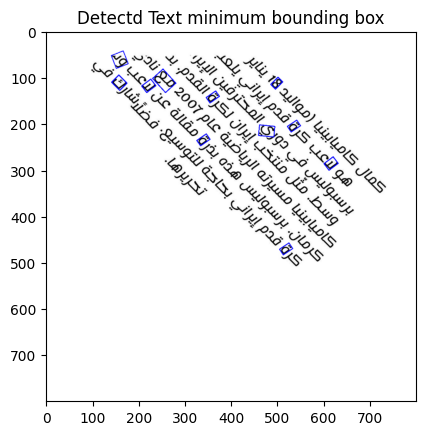

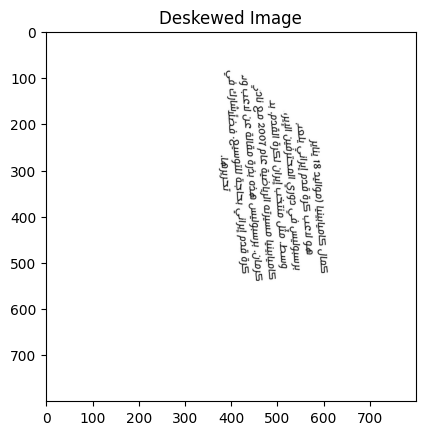

In [35]:
# 4) Rotate image
import cv2
import numpy as np

debug = True

#Display image
def display(img, frameName="OpenCV Image"):
    if not debug:
        return
    h, w = img.shape[0:2]
    neww = 800
    newh = int(neww*(h/w))
    img = cv2.resize(img, (neww, newh))
    show_images([img], [frameName])
    #cv2.imshow(frameName, img)
    cv2.waitKey(0)

#rotate the image with given theta value
def rotate(img, theta):
    rows, cols = img.shape[0], img.shape[1]
    image_center = (cols/2, rows/2)

    M = cv2.getRotationMatrix2D(image_center,theta,1)

    abs_cos = abs(M[0,0])
    abs_sin = abs(M[0,1])

    bound_w = int(rows * abs_sin + cols * abs_cos)
    bound_h = int(rows * abs_cos + cols * abs_sin)

    M[0, 2] += bound_w/2 - image_center[0]
    M[1, 2] += bound_h/2 - image_center[1]

    # rotate orignal image to show transformation
    rotated = cv2.warpAffine(img,M,(bound_w,bound_h),borderValue=(255,255,255))
    return rotated


def slope(x1, y1, x2, y2):
    if x1 == x2:
        return 0
    slope = (y2-y1)/(x2-x1)
    theta = np.rad2deg(np.arctan(slope))
    return theta


def main(filePath):
    img = cv2.imread(filePath)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #median = cv2.medianBlur(gray, 3)
    textImg = img.copy()

    small = cv2.cvtColor(textImg, cv2.COLOR_BGR2GRAY)
    #small = cv2.medianBlur(small, 3)

    #find the gradient map
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

    display(grad)

    #Binarize the gradient image
    _, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    display(bw)

    #connect horizontally oriented regions
    #kernal value (9,1) can be changed to improved the text detection
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    display(connected)

    # using RETR_EXTERNAL instead of RETR_CCOMP
    # _ , contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #opencv >= 4.0



    mask = np.zeros(bw.shape, dtype=np.uint8)
    #display(mask)
    #cumulative theta value
    cummTheta = 0
    #number of detected text regions
    ct = 0
    for idx in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[idx])
        mask[y:y+h, x:x+w] = 0
        #fill the contour
        cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
        #display(mask)
        #ratio of non-zero pixels in the filled region
        r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

        #assume at least 45% of the area is filled if it contains text
        if r > 0.45 and w > 8 and h > 8:
            #cv2.rectangle(textImg, (x1, y), (x+w-1, y+h-1), (0, 255, 0), 2)

            rect = cv2.minAreaRect(contours[idx])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(textImg,[box],0,(0,0,255),2)

            #we can filter theta as outlier based on other theta values
            #this will help in excluding the rare text region with different orientation from ususla value 
            theta = slope(box[0][0], box[0][1], box[1][0], box[1][1])
            cummTheta += theta
            ct +=1
            #print("Theta", theta)

    #find the average of all cumulative theta value
    orientation = cummTheta/ct
    print("Image orientation in degress: ", orientation)
    finalImage = rotate(img, orientation)
    display(textImg, "Detectd Text minimum bounding box")
    display(finalImage, "Deskewed Image")


filePath = "D:\Third_Year\\Neural\data_set\\fonts-dataset\Lemonada\\172.jpeg"
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
median = cv2.medianBlur(gray, 3)
main(filePath)